In [1]:
import sys
sys.path.append('C:/Users/Jonathan/Documents/srw_python/')

from srwlib import *
from uti_plot import *
from mpl_toolkits.axes_grid1 import ImageGrid
from itertools import zip_longest
from  AuxReadInMagFld3D import AuxReadInMagFld3D
from scipy.interpolate import griddata
from scipy import stats
from numpy.random import random, randn
import matplotlib.ticker as ticker
from matplotlib.cm import get_cmap
from matplotlib import gridspec

#from scipy.interpolate import interp2d

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
#fundamental constants
qe = 1.6021766208e-19
c = 299792458
mu_0 = 4*np.pi*1e-7
eps_0 = 1/(c**2*mu_0)
me = 9.10938356e-31
mp = 1.6726219e-27
h = 6.62607e-34
tau_m0 = 2.1969811e-6
mmu = 1.883531594e-28


In [6]:
#**********************Auxiliary function to write tabulated resulting Trajectory data to ASCII file:
def AuxSaveTrajData(traj, filePath):
    f = open(filePath, 'w')
    resStr = '#ct [m], X [m], BetaX [rad], Y [m], BetaY [rad], Z [m], BetaZ [rad]'
    if(hasattr(traj, 'arBx')):
        resStr += ', Bx [T]'
    if(hasattr(traj, 'arBy')):
        resStr += ', By [T]'
    if(hasattr(traj, 'arBz')):
        resStr += ', Bz [T]'
    f.write(resStr + '\n')
    ctStep = 0
    if traj.np > 0:
        ctStep = (traj.ctEnd - traj.ctStart)/(traj.np - 1)
    ct = traj.ctStart
    for i in range(traj.np):
        resStr = str(ct) + '\t' + repr(traj.arX[i]) + '\t' + repr(traj.arXp[i]) + '\t' + repr(traj.arY[i]) + '\t' + repr(traj.arYp[i]) + '\t' + repr(traj.arZ[i]) + '\t' + repr(traj.arZp[i])
        if(hasattr(traj, 'arBx')):
            resStr += '\t' + repr(traj.arBx[i])
        if(hasattr(traj, 'arBy')):
            resStr += '\t' + repr(traj.arBy[i])
        if(hasattr(traj, 'arBz')):
            resStr += '\t' + repr(traj.arBz[i])
        f.write(resStr + '\n')        
        ct += ctStep
    f.close()
    
    
def AuxSaveIntData(arI, mesh, filePath):
    f = open(filePath, 'w')
    f.write('#C-aligned Intensity (inner loop is vs photon energy, outer loop vs vertical position)\n')
    f.write('#' + repr(mesh.eStart) + ' #Initial Photon Energy [eV]\n')
    f.write('#' + repr(mesh.eFin) + ' #Final Photon Energy [eV]\n')
    f.write('#' + repr(mesh.ne) + ' #Number of points vs Photon Energy\n')
    f.write('#' + repr(mesh.xStart) + ' #Initial Horizontal Position [m]\n')
    f.write('#' + repr(mesh.xFin) + ' #Final Horizontal Position [m]\n')
    f.write('#' + repr(mesh.nx) + ' #Number of points vs Horizontal Position\n')
    f.write('#' + repr(mesh.yStart) + ' #Initial Vertical Position [m]\n')
    f.write('#' + repr(mesh.yFin) + ' #Final Vertical Position [m]\n')
    f.write('#' + repr(mesh.ny) + ' #Number of points vs Vertical Position\n')
    for i in range(mesh.ne*mesh.nx*mesh.ny): #write all data into one column using "C-alignment" as a "flat" 1D array
        f.write(' ' + repr(arI[i]) + '\n')
    f.close()

def plot_grid(data, Ng, colormap='gray_r'):
    sns.set_style("whitegrid", {'axes.grid' : False})

    fig = plt.figure(1, (16., 16.))
    grid = ImageGrid(fig, 111, nrows_ncols=(Ng,Ng), axes_pad=0.1)
    step = np.floor(np.shape(data)[0]/(Ng*Ng)).astype(np.int8)
    ilist = []
    Imax = np.max(data)
    for i in range(Ng*Ng):
        grid[i].imshow((data)[step*(i+1)], interpolation=None, cmap=colormap,\
                      vmin=0, vmax=Imax)
        ilist.append(step*(i+1))
    plt.show()
    return ilist


def data_zoom(data, spacing, new_spacing):
        spacing = np.array(spacing)
        print(spacing)
        new_shape = (data.shape*spacing / new_spacing)
        resize_factor = new_shape / data.shape
        new_spacing = spacing / resize_factor
        datazoom = zoom(data, resize_factor, mode='constant')
        
        return datazoom, new_spacing
    
    
def beta_avg(gamma, K, undPer=None, zpos=None):
    #computes the approximate average beta inside an undulator with parameter K; assumes gamma>>1
    if undPer:
        beta_avg = 1 - 1/(2*gamma**2) - K**2/(4*gamma**2)*(1 - np.cos(4*np.pi*zpos/undPer))
    else:
        beta_avg = 1 - 1/(2*gamma**2) - K**2/(4*gamma**2) 
    
    return beta_avg

#######################################################################################

def beta_gamma(pc, rest_energy):
    #calculates the relativistic beta and gamma using the KE and rest energy and returns a (beta,gamma) tuple
    #gamma = (1 + (pc/rest_energy)**2)**0.5 #for pc -> pc
    gamma = (1 + (pc/rest_energy)) # for pc -> Ekin
    
    beta = np.sqrt(1 - 1/gamma**2)
    
    return beta, gamma

######################################################################################

def BWconv(lmb,dlmb):
    
    lmb = lmb*1e-9
    dlmb = dlmb*1e-9
    
    E0 = h*c/(lmb)
    Es = h*c/(lmb+dlmb)
    Ef = h*c/(lmb-dlmb)
    
    return (Ef-E0)/qe, (Ef-E0)/h
#######################################################################################

def lmb_theta(theta, undPer, Kund, gamma):

    lmb_0 = undPer/(2*gamma**2)*(1 + Kund**2/2)
    lmb = lmb_0*(1 + (gamma*theta)**2 + Kund**2/2)/(1 + Kund**2/2)
    
    return lmb

#######################################################################################

def dpath(xgrid, ygrid, PE, lamb0, f0, d0, nconst):
    
    """
    Custom lens routine; creates a map of the desired xy optical-path difference vs photon energy.  This output should be
    concatenated with a transmission matrix of the same dimension along a new 4th dimension and then flattened;  SRW expects
    this C-style format as input for the SRWLOptT routine.
    
        xgrid: nx by ny grid of xvalues (m); output of np.meshgrid
        ygrid: nx by ny grid of yvalues (m); output of np.meshgrid
        PE: 1D array of photon energies in eV
        lamb0: wavelength of the fudamental; used for setting nominal parameters of the lens (um)
        f0: desired focal length for the fundamental (m)
        d0: physical thickness of the lens on axis (m)
        nconst: switch for sellmeir eqn; if ==0 use sellmeir eqn, use n = n0 otherwise
    """
    qe = 1.6021766208e-19
    c = 299792458
    h = 6.62607e-34
        
    ## Sellmeier equation for BaF2; returns index of refraction as a function of wavelength
    #BaF2
    #b1 = 0.643356; b2 = 0.506762; b3 = 3.8261; c1 = 0.057789**2; c2 = 0.10968**2; c3 = 46.3864**2
    #CaF2
    #b1 = 0.5675888; b2 = 0.4710914; b3 = 3.8484723; c1 = 0.050263605**2; c2 = 0.1003909**2; c3 = 34.649040**2;
    #SiO2
    #b1 = 0.6961663; b2 = 0.4079426; b3 = 0.8974794; c1 = 0.0684043**2; c2 = 0.1162414**2; c3 = 9.896161**2    
    #fused silica (CORNING-HPFS-7980)
    b1 = 0.68374049400; b2 = 0.42032361300; b3 = 0.58502748000; c1 = 0.00460352869; c2 = 0.01339688560; c3 = 64.49327320000
    #borosilicate crown glass (N-BK7)
    #b1 = 1.03961212; b2 = 0.231792344; b3 = 1.01046945; c1 = 0.00600069867; c2 = 0.0200179144; c3 = 103.560653
    
    n_0 = np.sqrt(1 + b1*lamb0**2/(lamb0**2 - c1) + b2*lamb0**2/(lamb0**2 - c2) + b3*lamb0**2/(lamb0**2 - c3))
    
    lamb = h*c/(PE*qe)*1e6
    n_sell = np.sqrt(1 + b1*lamb**2/(lamb**2 - c1) + b2*lamb**2/(lamb**2 - c2) + b3*lamb**2/(lamb**2 - c3))
    
    if nconst:
        n_sell = np.ones_like(n_sell)*n_0
    
    #R0 = f0*2*(n_0 - 1) #biconvex/biconcave, thin lens
    R0 = np.roots([1, -(n_0 - 1)*2*f0, (n_0 - 1)**2/(2*n_0)*d0])[0] #biconvex thick lens
    invfout = (n_sell - 1)*(2/R0 - (n_sell - 1)*d0/(n_sell*R0**2))

    ds = ((n_sell - 1)*d0 - (xgrid**2 + ygrid**2)[...,None]*invfout/2)

    return ds

In [7]:
#beam constants
fring = 7.5e6 #IOTA frequency
Ekin = 99.49 #MeV
Erest = me*c**2/qe/1e6 #MeV
part_bg = beta_gamma(Ekin, Erest)
print(part_bg)

(0.9999869441794592, 195.69707467400994)


In [8]:
#**********************Dir and files:
strExDataFolderName = 'OSC_03' #example data sub-folder name
strTrajOutFileName = strExDataFolderName + '_traj.dat' #file name for output trajectory data
strIntOutFileName1 = strExDataFolderName + '_int1.dat' #file name for output SR intensity data
strIntOutFileName2 = strExDataFolderName + '_int2.dat' #file name for output SR intensity data

In [9]:
#**********************Undulator constants:
numPer = 14 #16#6#Number of ID Periods (without counting for terminations; semi-integer => symmetric vs long. pos.; to allow harmonics to be symmetric or anti-symmetric?)
undPer = 0.0484#0.04777 #0.1106 #Period Length [m]
By = 0.222 #0.2327 #0.1005 #Peak Vertical field [T]
phBy = 0 #Initial Phase of the Vertical field component
Kund = qe*By*undPer/(2*np.pi*me*c)

In [10]:
#specify a given design trajectory error relative to nominal optical axis(x0,x0',y0,y0')
qxi = 0.00; qyi = 0.00; x0i = 0.000; y0i = 0.000;
#qxi = 0.00; qyi = -0.00; x0i = 0.00; y0i = 0.00;

zleft = -0.5*(numPer + 4)*undPer

#**********************Initial Conditions for Particle Trajectory Calculation
part = SRWLParticle()
part.x = np.tan(qxi)*zleft + x0i #Initial Transverse Coordinates (initial Longitudinal Coordinate will be defined later on) [m]
part.y = np.tan(qyi)*zleft + y0i
part.z = zleft #Initial Longitudinal Coordinate (set 2 periods before pickup)
part.xp = qxi #Initial Transverse angles (rad)
part.yp = qyi
part.gamma = part_bg[1] #Relative Energy
part.relE0 = 1 #Electron Rest Mass
part.nq = -1 #Electron Charge

In [13]:
#**********************Trajectory structure, where the results will be stored
fmult = 1.0
npTraj = 20000 #Number of Points for Trajectory calculation
dispBy = array('d', [0]*npTraj)
partTraj = SRWLPrtTrj(_arBy=dispBy)
partTraj.partInitCond = part
partTraj.allocate(npTraj, False)
partTraj.ctStart = 0.0 #Start Time for the calculation
partTraj.ctEnd = fmult*undPer*(numPer+4) #End Time ~1.2166

#**********************Undulator constants:
#numPer = 6 #6#Number of ID Periods (without counting for terminations; semi-integer => symmetric vs long. pos.; to allow harmonics to be symmetric or anti-symmetric?)
#undPer = 0.1106 #Period Length [m]
#By = 0.1005 #Peak Vertical field [T]
#Bd = 0.1424
#phBy = 0 #Initial Phase of the Vertical field component
#Kund = qe*By*undPer/(2*np.pi*me*c)
Lund = numPer*undPer

#***********Magnetic Field
sBy = 1 #Symmetry of the Vertical field component vs Longitudinal position
xcID = 0 #Transverse Coordinates of Undulator Center [m]
ycID = 0
zcID = 0 #Longitudinal Coordinate of Undulator Center [m]

xcDp = 0
ycDp = 0
zcDp = 0.893334

#xcDp2 = 0.0352
#zcDp2 = zcDp + 0.588548
#zcDp3 = zcDp2 + 0.5
#zcDp4 = zcDp3 + 0.588548

und = SRWLMagFldU([SRWLMagFldH(1, 'v', By, phBy, sBy, 1)], undPer, numPer) #Planar Undulator
#odip1 = SRWLMagFldM(Bd,1,'n',_Leff=0.08) 
#odip2 = SRWLMagFldM(-Bd,1,'n',_Leff=0.08) 
#odip3 = SRWLMagFldM(-Bd,1,'n',_Leff=0.08) 
#odip4 = SRWLMagFldM(Bd,1,'n',_Leff=0.08) 

#magFldCnt = SRWLMagFldC([und,odip1,odip2,odip3,odip4], array('d', [xcID,xcDp,xcDp2,xcDp2,xcDp]), array('d', [ycID,ycDp,ycDp,ycDp,ycDp]), array('d', [zcID,zcDp,zcDp2,zcDp3,zcDp4])) #Container of all Field Elements
#magFldCnt = SRWLMagFldC([und,odip1], array('d', [xcID,xcDp]), array('d', [ycID,ycDp]), array('d', [zcID,zcDp])) #Container of all Field Elements
magFldCnt = SRWLMagFldC([und], array('d', [xcID]), array('d', [ycID]), array('d', [zcID])) #Container of all Field Elements

In [14]:
##########################################
#***********Magnetic Field
#und = SRWLMagFldU([SRWLMagFldH(1, 'v', By, phBy, sBy, 1)], undPer, numPer) #Planar Undulator
#magFldCnt = SRWLMagFldC([und], array('d', [xcID]), array('d', [ycID]), array('d', [zcID])) #Container of all Field Elements

print('   Tabulating Magnetic Field for display ... ', end='')
dispMagFld3D = SRWLMagFld3D(_arBy=dispBy, _nx=1, _ny=1, _nz=npTraj, _rz=partTraj.ctEnd)
xDisp = part.x
yDisp = part.y
dispMagFldCnt = SRWLMagFldC([dispMagFld3D], array('d', [xDisp]), array('d', [yDisp]), array('d', [0]))
srwl.CalcMagnField(dispMagFldCnt, magFldCnt)
print('done')

   Tabulating Magnetic Field for display ... done


In [15]:
np.asarray(dispMagFldCnt)

array(<srwlib.SRWLMagFldC object at 0x000001D3AA222B48>, dtype=object)

In [16]:
partTraj = srwl.CalcPartTraj(partTraj, magFldCnt, 0)

arX = np.asarray(partTraj.arX)
arZ = np.asarray(partTraj.arZ)
arXp = np.asarray(partTraj.arXp)
arZp = np.asarray(partTraj.arZp)

ct_list = np.linspace(partTraj.ctStart, partTraj.ctEnd, partTraj.np)

In [17]:
#**********************Calculation (SRWLIB function call)
#print('   Performing Trajectory calculation ... ', end='')
#partTraj = srwl.CalcPartTraj(partTraj, magFldCnt, 0)
#print('done')

#**********************Saving trajectory results
print('   Saving Trajectory data to a file ... ', end='')
AuxSaveTrajData(partTraj, os.path.join(os.getcwd(), strExDataFolderName, strTrajOutFileName))
print('done')

   Saving Trajectory data to a file ... done


In [18]:
#efficient conversion to numpy arrays by pulling from buffer
#arX = np.frombuffer(partTraj.arX)
arX = np.asarray(partTraj.arX)
arY = np.asarray(partTraj.arY)
arZ = np.asarray(partTraj.arZ)
#arY = np.frombuffer(partTraj.arY)
#arXp = np.frombuffer(partTraj.arXp)
arBy = np.frombuffer(partTraj.arBy)

In [19]:
ct_list = np.linspace(partTraj.ctStart, partTraj.ctEnd, partTraj.np)

In [20]:
darZ = (arZ[-1] - arZ[0])/len(arZ)
arBy_n = arBy/np.max(np.absolute(arBy))

In [21]:
print(darZ*arBy_n.sum())

-1.067087271652047e-09


In [22]:
Bsave = np.vstack([arZ,arBy]).T
np.save('950nm-und_SRWfield_03.npy', Bsave)

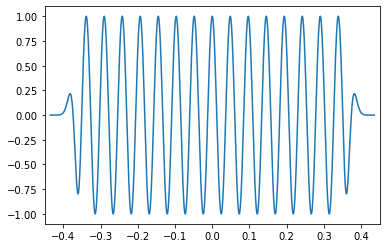

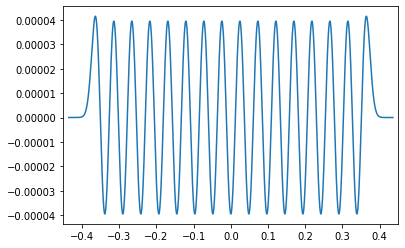

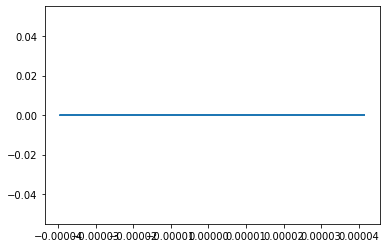

In [23]:
plt.plot(arZ, arBy_n)
plt.xlim(-0.45,0.45)

plt.show()

plt.plot(arZ, arX)
plt.xlim(-0.45,0.45)

plt.show()

plt.plot(arX, arY)
#plt.xlim(-0.45,0.45)

plt.show()

0.20223018129026277


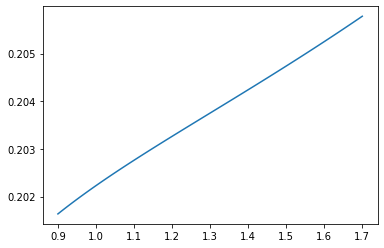

In [24]:
## CHECKING CHROMATICITY OF LENSES ##
lamb0 = 0.5876 #nominal TL design wavelength
lamb1 = 1.00 #OSC UR BPM design wavelength (center)
lamb = np.linspace(0.9,1.7,100)

b1 = 1.03961212; b2 = 0.231792344; b3 = 1.01046945; c1 = 0.00600069867; c2 = 0.0200179144; c3 = 103.560653
n_0 = np.sqrt(1 + b1*lamb0**2/(lamb0**2 - c1) + b2*lamb0**2/(lamb0**2 - c2) + b3*lamb0**2/(lamb0**2 - c3))
n_1 = np.sqrt(1 + b1*lamb1**2/(lamb1**2 - c1) + b2*lamb1**2/(lamb1**2 - c2) + b3*lamb1**2/(lamb1**2 - c3))

#lamb = h*c/(PE*qe)*1e6
n_sell = np.sqrt(1 + b1*lamb**2/(lamb**2 - c1) + b2*lamb**2/(lamb**2 - c2) + b3*lamb**2/(lamb**2 - c3))

## N-BK7 200mm, uncoated BCX lens from thorlabs
f0 = 0.1993
d0 = 2.8e-3

f0_o = 0.9967
d0_o = 3.6e-3

R0 = np.roots([1, -(n_0 - 1)*2*f0, (n_0 - 1)**2/(2*n_0)*d0])[0]
R0_o = np.roots([1, -(n_0 - 1)*2*f0_o, (n_0 - 1)**2/(2*n_0)*d0_o])[0]

invfout = (n_sell - 1)*(2/R0 - (n_sell - 1)*d0/(n_sell*R0**2))
invfout_1 = (n_1 - 1)*(2/R0 - (n_1 - 1)*d0/(n_1*R0**2))
invfout_o = (n_1 - 1)*(2/R0_o - (n_1 - 1)*d0_o/(n_1*R0_o**2))

#df/f0
#plt.plot(lamb,invfout**(-1)/f0- 1)
print(invfout_1**(-1))
plt.plot(lamb,invfout**(-1))

In [25]:
invfout_o**(-1)

1.0152513373426433

In [26]:
invfout_1**(-1)

0.20223018129026277

0.9916531055280153


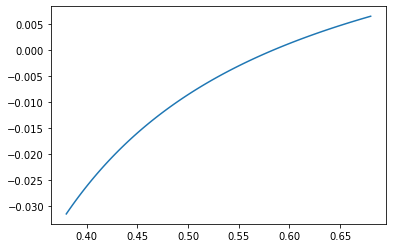

In [27]:
## CHECKING CHROMATICITY OF LENSES ##
lamb0 = 0.5876 #nominal TL design wavelength
lamb1 = 0.530 #OSC UR BPM design wavelength (center)
lamb = np.linspace(0.38,0.68,100)

b1 = 1.03961212; b2 = 0.231792344; b3 = 1.01046945; c1 = 0.00600069867; c2 = 0.0200179144; c3 = 103.560653
n_0 = np.sqrt(1 + b1*lamb0**2/(lamb0**2 - c1) + b2*lamb0**2/(lamb0**2 - c2) + b3*lamb0**2/(lamb0**2 - c3))
n_1 = np.sqrt(1 + b1*lamb1**2/(lamb1**2 - c1) + b2*lamb1**2/(lamb1**2 - c2) + b3*lamb1**2/(lamb1**2 - c3))

#lamb = h*c/(PE*qe)*1e6
n_sell = np.sqrt(1 + b1*lamb**2/(lamb**2 - c1) + b2*lamb**2/(lamb**2 - c2) + b3*lamb**2/(lamb**2 - c3))

## N-BK7 1000mm, uncoated BCX lens from thorlabs
f0 = 0.9967
d0 = 3.6e-3

R0 = np.roots([1, -(n_0 - 1)*2*f0, (n_0 - 1)**2/(2*n_0)*d0])[0]

invfout = (n_sell - 1)*(2/R0 - (n_sell - 1)*d0/(n_sell*R0**2))
invfout_1 = (n_1 - 1)*(2/R0 - (n_1 - 1)*d0/(n_1*R0**2))
#df/f0
plt.plot(lamb,invfout**(-1)/f0- 1)
print(invfout_1**(-1))


In [30]:
#***********Electron Beam
f_ring = 7.5e6
Iavg_se = qe*f_ring

elecBeam = SRWLPartBeam()
elecBeam.Iavg = Iavg_se #Average Current [A]
elecBeam.partStatMom1 = part

Iavg_se

1.2016324656000001e-12

In [31]:
#***********Precision Parameters for SR calculation
meth = 1 #SR calculation method: 0- "manual", 1- "auto-undulator", 2- "auto-wiggler"
relPrec = 0.001 #relative precision
zStartInteg = 0 #longitudinal position to start integration (effective if < zEndInteg)
zEndInteg = 0 #longitudinal position to finish integration (effective if > zStartInteg)
useTermin = 1 #Use "terminating terms" (i.e. asymptotic expansions at zStartInteg and zEndInteg) or not (1 or 0 respectively)
sampFactNxNyForProp = 0 #sampling factor for adjusting nx, ny (effective if > 0)
arPrecPar = [meth, relPrec, zStartInteg, zEndInteg, npTraj, useTermin, sampFactNxNyForProp]

lmb_0 = undPer/(2*part.gamma**2)*(1 + Kund**2/2)
PE_0 = c*h/qe/lmb_0 
#z_0 = 1.43
#z_0 = 1.75
z_0 = 1.72765
th_max = 1./part.gamma
y_c = np.tan(th_max)*z_0
xs = -y_c
xf = y_c
print(y_c,th_max)

0.008828261946151864 0.005109938417146956


In [32]:
#thlist = np.linspace(0,th_max,10)
#Elist = np.linspace(3.01,3.12,20)
nE = 13
Elist = np.linspace(1.18, 1.3, nE)

In [33]:
gth_d = 0.6946
Nx = 1024; 
dzobs = (numPer + 4)*undPer/2
lmb_angle = lmb_theta(gth_d/part.gamma, undPer, Kund, part.gamma)
lmb0 = lmb_theta(0, undPer, Kund, part.gamma)
#lmb_0 = undPer/(2*part.gamma**2)*(1 + Kund**2/2)
lmb_m = 1.05e-06 #from integrating spectra power distribution in other worksheet
thmax = ((lmb_m - lmb0)*(1+Kund**2/2)/(part.gamma**2*lmb0))**0.5 #angle where max integrated power occurs
ftup = (0.75,)#(0.25,-0.025,0.25)
dztup = (1.5,)#(1.5,0.025,0.25)
zsep = 0.6 
dzC1 = 1.286#dztup[1] - zsep/2 
dzcams = 0.714#zsep
xmax = 0.015

lmb_angle = lmb_theta(gth_d, undPer, Kund, part.gamma)
lmb0 = lmb_theta(0, undPer, Kund, part.gamma)

In [71]:
#Elist = np.linspace(2.175,2.34,20)
#Elist = np.linspace(3.01,3.12,20)
dUL1 = 2.060
dL1L2 = 0.8295
#dL2AD = 0.2

dzlens2 = 0.8295 #1.1567692183088814 #1.286 #dztup[1] - zsep/2 
dzdet = 0.1724972497249725 #0.17 #.16104094231325666#0.714 #zsep
xmax = 0.02
xlims = (-xmax,xmax)
dzlens = 2.060#2.191748-0.255#1.5

lamb0 = 0.5876 #nominal TL design wavelength
lamb1 = 1.00 #OSC UR BPM design wavelength (center)

flens1 = 1.0152513373426433 #1.01
flens1_0 = 0.9967
d1 = 3.6e-3

flens2 = 0.20223018129026277 #0.2
flens2_0 = 0.1993
d2 = 2.8e-3

nmesh = 1024
Elims = (Elist[0],Elist[-1])
#e_val = 2.25426#3.05##1.18080#3.9#3.06134#
elims = Elims

nE = len(Elist)
#***********Precision Parameters for SR calculation
meth = 1 #SR calculation method: 0- "manual", 1- "auto-undulator", 2- "auto-wiggler"
relPrec = 0.001 #relative precision
zStartInteg = 0 #longitudinal position to start integration (effective if < zEndInteg)
zEndInteg = 0 #longitudinal position to finish integration (effective if > zStartInteg)
useTermin = 1 #Use "terminating terms" (i.e. asymptotic expansions at zStartInteg and zEndInteg) or not (1 or 0 respectively)
sampFactNxNyForProp = 0 #sampling factor for adjusting nx, ny (effective if > 0)
arPrecPar = [meth, relPrec, zStartInteg, zEndInteg, npTraj, useTermin, sampFactNxNyForProp]

#**********Optics
PE = np.linspace(Elims[0], Elims[1], nE)
de = PE[1] - PE[0]
    
x_list = np.linspace(xlims[0], xlims[1], nmesh)
xmesh, ymesh = np.meshgrid(x_list,x_list)
        
ap = SRWLOptA('c','a',0.03,0.03,0.0,0.0)
#ap_ri = SRWLOptA('c','o',2*alims[0],2*alims[0],0.0,0.0)
#ap_ro = SRWLOptA('c','a',2*alims[1],2*alims[1],0.0,0.0)

#drift_list = [SRWLOptD(d) for d in dzlens[1:]]

#opt_list = [y for x in zip_longest(lens_list, drift_list) for y in x if y is not None]
    
#Wavefront Propagation Parameters:
#[0]: Auto-Resize (1) or not (0) Before propagation
#[1]: Auto-Resize (1) or not (0) After propagation
#[2]: Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[3]: Allow (1) or not (0) for semi-analytical treatment of the quadratic (leading) phase terms at the propagation
#[4]: Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[5]: Horizontal Range modification factor at Resizing (1. means no modification)
#[6]: Horizontal Resolution modification factor at Resizing
#[7]: Vertical Range modification factor at Resizing
#[8]: Vertical Resolution modification factor at Resizing
#[9]: Type of wavefront Shift before Resizing (not yet implemented)
#[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
#[11]: New Vertical wavefront Center position after Shift (not yet implemented)
#               [0][1][2] [3][4] [5] [6]  [7] [8] [9][10][11] 
propagParLens = [0, 0, 1, 0, 0, 1., 1., 1., 1., 0, 0, 0]
propagParDrift = [0, 0, 1, 0, 0, 1., 1., 1., 1., 0, 0, 0]
propagParDrift_re = [0, 0, 1, 0, 0, 2/3, 3/2, 2/3, 3/2, 0, 0, 0]
proplens = [propagParLens, propagParDrift, propagParLens, propagParDrift, propagParLens]

#lens1 = SRWLOptL(flens1,flens1)
#lens2 = SRWLOptL(flens2,flens2)
ds = dpath(xmesh, ymesh, PE, lamb0, flens1_0, d1, nconst=0)
tr_ds = np.concatenate((np.ones_like(ds)[...,np.newaxis],ds[...,np.newaxis]),axis=3)
tr_ds = tr_ds.flatten()
#NOTE: the range variables for SRWLOptT specify the magnitude of the ENTIRE range, not half of it
lens1 = (SRWLOptT(nmesh,nmesh,2*xmax,2*xmax,tr_ds,0,flens1,flens1,0,0,nE,Elist[0],Elist[-1]))
del(ds); del(tr_ds);

x_list2 = np.linspace(-xmax*(2/3)**3, xmax*(2/3)**3, nmesh)
xmesh2, ymesh2 = np.meshgrid(x_list2,x_list2)
ds = dpath(xmesh2, ymesh2, PE, lamb0, flens2_0, d2, nconst=0)
tr_ds = np.concatenate((np.ones_like(ds)[...,np.newaxis],ds[...,np.newaxis]),axis=3)
tr_ds = tr_ds.flatten()
#NOTE: the range variables for SRWLOptT specify the magnitude of the ENTIRE range, not half of it
lens2 = (SRWLOptT(nmesh,nmesh,2*xmax*(2/3)**3,2*xmax*(2/3)**3,tr_ds,0,flens2,flens2,0,0,nE,Elist[0],Elist[-1]))
del(ds); del(tr_ds);

drift_L2 = SRWLOptD(dzlens2/3)
drift_det = SRWLOptD((dzdet)/3)

#optC2 = SRWLOptC([SRWLOptD(dzcams)],[propagParDrift]) 

optC1 = SRWLOptC([ap, lens1, drift_L2, drift_L2, drift_L2],\
                 [propagParLens, propagParLens, propagParDrift_re, propagParDrift_re, propagParDrift_re])

optC2 = SRWLOptC([lens2, drift_det, drift_det, drift_det],\
                 [propagParLens, propagParDrift_re, propagParDrift_re, propagParDrift_re,])

print('Running SRW routines')

Pdist_L = []
Psum_L = []
Pdist_C1 = []
Psum_C1 = []
Pdist_C2 = []
Psum_C2 = []

t0 = time.time()

for ie,e_val in enumerate(PE):  #loop through each energy

    if (e_val>elims[0] and e_val<elims[1]):  #only do srw calcs in a selected energy range; zero otherwise

        pc = ie/nE*100 #(ie - elims[0]/de)/(elims[1]/de - elims[0]/de)*100
        #pc = ie/((elims[1]-elims[0])/(PE[1]-PE[0]))*100

        wfr = SRWLWfr()
        wfr.allocate(1, nmesh, nmesh) #Numbers of points vs Photon Energy, Horizontal and Vertical Positions
        wfr.mesh.eStart = e_val #Initial Photon Energy [eV]
        wfr.mesh.eFin =  e_val #Final Photon Energy [eV]
        wfr.mesh.xStart = xlims[0] #Initial Horizontal Position [m]
        wfr.mesh.xFin = xlims[1] #Final Horizontal Position [m]
        wfr.mesh.yStart = xlims[0] #Initial Vertical Position [m]
        wfr.mesh.yFin = xlims[1] #Final Vertical Position [m]
        wfr.partBeam = elecBeam
        wfr.mesh.zStart = dzlens #position of the first lens [m]
        wfr.presCA = 0 #position representation 

        wfr2 = SRWLWfr()
        wfr2.allocate(1, nmesh, nmesh) #Numbers of points vs Photon Energy, Horizontal and Vertical Positions
        wfr2.mesh.eStart = e_val #Initial Photon Energy [eV]
        wfr2.mesh.eFin =  e_val #Final Photon Energy [eV]
        wfr2.mesh.xStart = xlims[0] #Initial Horizontal Position [m]
        wfr2.mesh.xFin = xlims[1] #Final Horizontal Position [m]
        wfr2.mesh.yStart = xlims[0] #Initial Vertical Position [m]
        wfr2.mesh.yFin = xlims[1] #Final Vertical Position [m]
        wfr2.partBeam = elecBeam
        wfr2.mesh.zStart = dzlens #position of the first lens [m]
        wfr2.presCA = 0 #position representation 

        wfr3 = SRWLWfr()
        wfr3.allocate(1, nmesh, nmesh) #Numbers of points vs Photon Energy, Horizontal and Vertical Positions
        wfr3.mesh.eStart = e_val #Initial Photon Energy [eV]
        wfr3.mesh.eFin =  e_val #Final Photon Energy [eV]
        wfr3.mesh.xStart = xlims[0] #Initial Horizontal Position [m]
        wfr3.mesh.xFin = xlims[1] #Final Horizontal Position [m]
        wfr3.mesh.yStart = xlims[0] #Initial Vertical Position [m]
        wfr3.mesh.yFin = xlims[1] #Final Vertical Position [m]
        wfr3.partBeam = elecBeam
        wfr3.mesh.zStart = dzlens #position of the first lens [m]
        wfr3.presCA = 0 #position representation 
        
        srwl.CalcElecFieldSR(wfr, 0, magFldCnt, arPrecPar)

        #Compute intensity at Camera1 for this photon energy
        arI_L = array('f', [0]*wfr.mesh.nx*wfr.mesh.ny) #"flat" array to take 2D intensity data
        srwl.CalcIntFromElecField(arI_L, wfr, 6, 0, 3, wfr.mesh.eStart, 0, 0)
        #print('field at lens: done; ', wfr.mesh.nx, wfr.mesh.ny)
        arInp_L = np.reshape(np.asarray(arI_L),(wfr.mesh.nx,wfr.mesh.ny))
        Pdist_L.append(arInp_L)
        Psum_L.append(arInp_L.sum())
        
        srwl.CalcElecFieldSR(wfr2, 0, magFldCnt, arPrecPar)
        srwl.PropagElecField(wfr2, optC1)
        arI_C1 = array('f', [0]*wfr2.mesh.nx*wfr2.mesh.ny) #"flat" array to take 2D intensity data
        srwl.CalcIntFromElecField(arI_C1, wfr2, 6, 0, 3, wfr2.mesh.eStart, 0, 0)
        #print('field at C1: done; ', wfr.mesh.nx, wfr.mesh.ny)
        arInp_C1 = np.reshape(np.asarray(arI_C1),(wfr.mesh.nx,wfr.mesh.ny))
        Pdist_C1.append(arInp_C1)
        Psum_C1.append(arInp_C1.sum())
        
        srwl.CalcElecFieldSR(wfr3, 0, magFldCnt, arPrecPar)
        srwl.PropagElecField(wfr3, optC1)
        srwl.PropagElecField(wfr3, optC2)
        arI_C2 = array('f', [0]*wfr3.mesh.nx*wfr3.mesh.ny) #"flat" array to take 2D intensity data
        srwl.CalcIntFromElecField(arI_C2, wfr3, 6, 0, 3, wfr3.mesh.eStart, 0, 0)
        #print('field at C2: done; ', wfr2.mesh.nx, wfr2.mesh.ny)
        arInp_C2 = np.reshape(np.asarray(arI_C2),(wfr3.mesh.nx,wfr3.mesh.ny))
        Pdist_C2.append(arInp_C2)
        Psum_C2.append(arInp_C2.sum())
        
        ti = time.time()
        
        print('Current photon energy: {:.3f};  '.format(e_val), 'percent completed: {:.2f}'.format(pc), 'current time: {:.2f}'.format((ti-t0)/60))
        
    else:
        Pdist_L.append(np.zeros((nmesh,nmesh)))
        Psum_L.append(0)
        Pdist_C1.append(np.zeros((nmesh,nmesh)))
        Psum_C1.append(0)
        Pdist_C2.append(np.zeros((nmesh,nmesh)))
        Psum_C2.append(0)        
        
print('PROPAGATION FOR ALL ENERGIES COMPLETED')

######################################################################################################################

Running SRW routines
Current photon energy: 1.190;   percent completed: 7.69 current time: 0.57
Current photon energy: 1.200;   percent completed: 15.38 current time: 1.14
Current photon energy: 1.210;   percent completed: 23.08 current time: 1.71
Current photon energy: 1.220;   percent completed: 30.77 current time: 2.27
Current photon energy: 1.230;   percent completed: 38.46 current time: 2.82
Current photon energy: 1.240;   percent completed: 46.15 current time: 3.37
Current photon energy: 1.250;   percent completed: 53.85 current time: 3.92
Current photon energy: 1.260;   percent completed: 61.54 current time: 4.48
Current photon energy: 1.270;   percent completed: 69.23 current time: 5.05
Current photon energy: 1.280;   percent completed: 76.92 current time: 5.62
Current photon energy: 1.290;   percent completed: 84.62 current time: 6.19
PROPAGATION FOR ALL ENERGIES COMPLETED


In [89]:
#### NOTE, total energy at "C1" and "C2" should match but likely will not match the energy at "L" due to loss from the aperture ####

#dx = (xf-xs)/wfr2.mesh.nx; dy = dx
dx = (wfr.mesh.xFin - wfr.mesh.xStart)/wfr.mesh.nx; dy = (wfr.mesh.yFin - wfr.mesh.yStart)/wfr.mesh.ny
dx1 = (wfr2.mesh.xFin - wfr2.mesh.xStart)/wfr2.mesh.nx; dy1 = (wfr2.mesh.yFin - wfr2.mesh.yStart)/wfr2.mesh.ny
dx2 = (wfr3.mesh.xFin - wfr3.mesh.xStart)/wfr3.mesh.nx; dy2 = (wfr3.mesh.yFin - wfr3.mesh.yStart)/wfr3.mesh.ny

Cs = 1e9*qe/Iavg_se*dx*dy
Cs1 = 1e9*qe/Iavg_se*dx1*dy1
Cs2 = 1e9*qe/Iavg_se*dx2*dy2
#dE = qe*(Elist[1]-Elist[0])
dE = qe*(Elist[1]-Elist[0])

Pdist_arL = np.asarray(Pdist_L)
Pdist_arC1 = np.asarray(Pdist_C1)
Pdist_arC2 = np.asarray(Pdist_C2)

djC1 = Cs1*Pdist_arC1
dJC1 = djC1.sum(axis=(1,2))
djC2 = Cs2*Pdist_arC2
dJC2 = djC2.sum(axis=(1,2))
djL = Cs*Pdist_arL
dJL = djL.sum(axis=(1,2))

print(' total energy at lens #1: {:.3} eV'.format(djL.sum()*dE/qe), '\n', 'total energy at lens #2: {:.3} eV'.format(djC1.sum()*dE/qe), '\n', 'total energy at diode: {:.3} eV'.format(djC2.sum()*dE/qe))

 total energy at lens #1: 0.0183 eV 
 total energy at lens #2: 0.0158 eV 
 total energy at diode: 0.0158 eV


In [74]:
0.841/part.gamma

0.00429745820882059

In [75]:
lmb_angle = lmb_theta(0.0043, undPer, Kund, part.gamma)
lmb_angle

1.3973760297865407e-06

In [86]:
np.save('11-01-20_Pdist_C1_TOT.npy', Pdist_C1)
np.save('11-01-20_Pdist_C2_TOT.npy', Pdist_C2)
np.save('11-01-20_Pdist_L_TOT.npy', Pdist_L)
np.save('11-01-20_Psum_C1_TOT.npy', Psum_C1)
np.save('11-01-20_Psum_C2_TOT.npy', Psum_C2)
np.save('11-01-20_Psum_L_TOT.npy', Psum_L)
np.save('11-01-20_Elist_TOT.npy', Elist)
np.save('11-01-20_x_1.npy', np.linspace(wfr.mesh.xStart, wfr.mesh.xFin,wfr.mesh.nx))
np.save('11-01-20_x_2.npy', np.linspace(wfr2.mesh.xStart, wfr2.mesh.xFin,wfr2.mesh.nx))
np.save('11-01-20_x_3.npy', np.linspace(wfr3.mesh.xStart, wfr3.mesh.xFin,wfr3.mesh.nx))

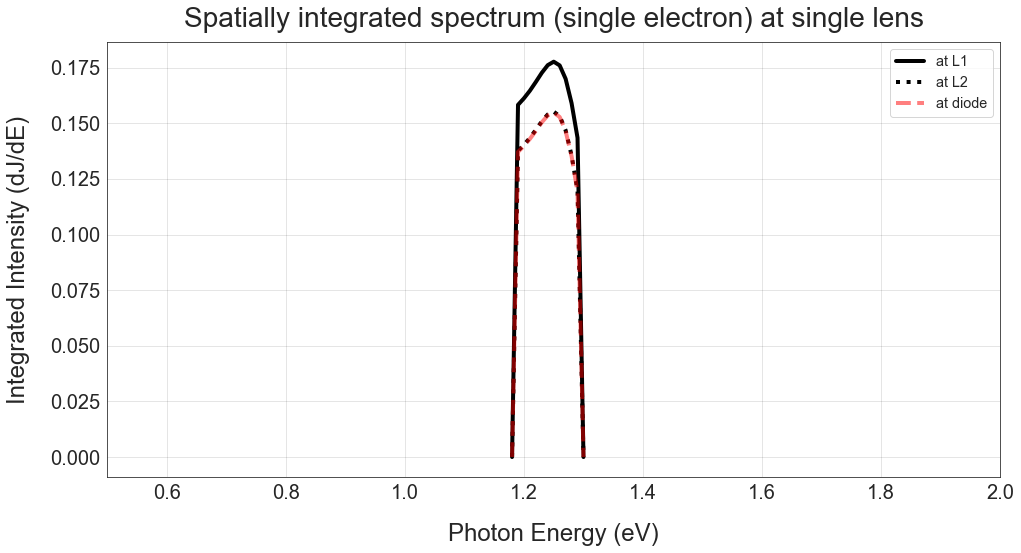

In [80]:
with sns.axes_style("white"):

    fig,ax = plt.subplots(figsize=[16,8])
    plt.plot(Elist, dJL, linewidth=4, color='k', linestyle='-', label=r'at L1')
    plt.plot(Elist, dJC1, linewidth=4, color='k', linestyle=':', label=r'at L2')
    plt.plot(Elist, dJC2, linewidth=4, color='r', alpha=0.5, linestyle='--', label=r'at diode')


    #plt.plot(e_list, eI0_1, linewidth=4, color='k', linestyle='-.', label=r'$y(\theta_{max}/2)$')
    #plt.plot(e_list, eI0_2, linewidth=4, color='k', linestyle='--', label=r'$y(\theta_{max})$')
    
    plt.title('Spatially integrated spectrum (single electron) at single lens', fontsize=28, y=1.02)

    legend = ax.legend(loc='upper right', shadow=False, fontsize='x-large', frameon=True)
    #ax.set_ylim([-0.125,0.125])
    ax.set_xlabel('Photon Energy (eV)', fontsize='24', labelpad=20)
    ax.set_ylabel('Integrated Intensity (dJ/dE)', fontsize='24', labelpad=20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)
    ax.grid(color='k', linestyle='-', linewidth=1, alpha=0.1)
    ax.set_xlim([0.5, 2])
    #ax.set_ylim([0, 0.17])

    frame = legend.get_frame()
    frame.set_facecolor('1')
    #plt.text(3.2,0.06,r'Jtotal = {:.4f} (eV)'.format(dJ.sum()*dE/qe),rotation=0, color='k', fontsize=30)

    
    plt.show()

In [97]:
#approximate # of counts per second for SPAD at avg QE for this band (~12%)... beam splitters included but not other optics

QEavg = 0.12

dJC2.sum()*dE/qe/((Elist[-1]+Elist[0])/2)*fring/2*QEavg

5730.289775793968

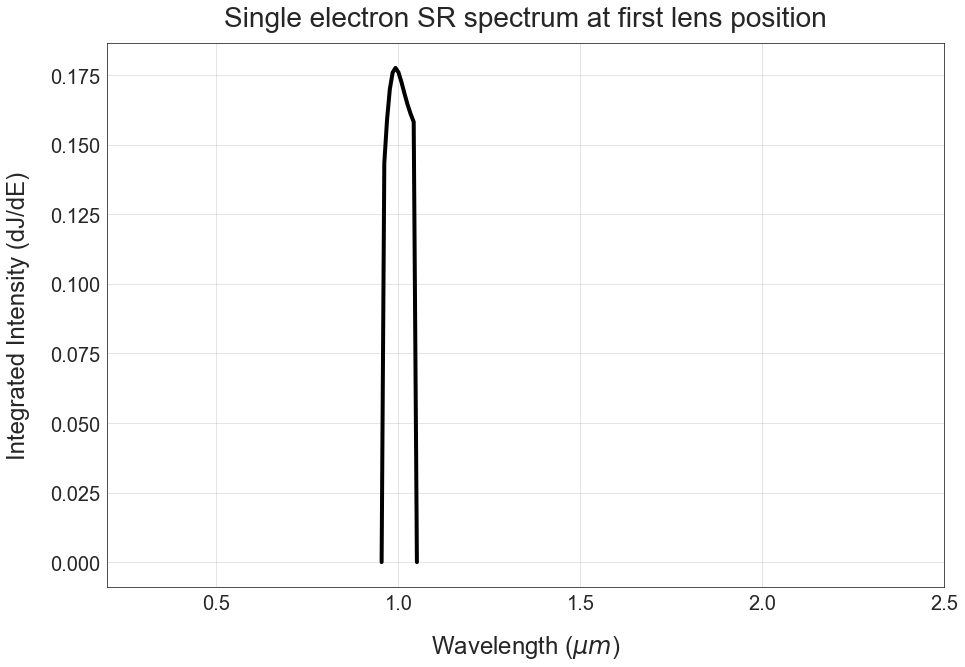

In [91]:
with sns.axes_style("white"):

    fig,ax = plt.subplots(figsize=[15,10])
    #plt.plot(h*c/(Elist*qe)*1e6, np.asarray(Psum_list_143)/(1.75/1.43)**2, linewidth=4, color='k', label='telescope')
    #plt.plot(h*c/(Elist*qe)*1e6, Psum_list_143, linewidth=4, color='k', linestyle=':', label=r'telescope: $\gamma \theta = $ 0.8')
    #plt.plot(h*c/(Elist*qe)*1e6, np.asarray(Psum_list_175)*(1.75/1.43)**2, linewidth=4, color='k', linestyle='-.', label=r'single lens: $\gamma \theta = $ 0.8')
    plt.plot(h*c/(Elist*qe)*1e6, np.asarray(dJL), linewidth=4, color='k', linestyle='-', label=r'single lens: $\gamma \theta = $ 0.8')


    #plt.plot(e_list, eI0_1, linewidth=4, color='k', linestyle='-.', label=r'$y(\theta_{max}/2)$')
    #plt.plot(e_list, eI0_2, linewidth=4, color='k', linestyle='--', label=r'$y(\theta_{max})$')
    
    plt.title('Single electron SR spectrum at first lens position', fontsize=28, y=1.02)

    #legend = ax.legend(loc='upper right', shadow=False, fontsize='x-large', frameon=True)
    #ax.set_ylim([-0.125,0.125])
    ax.set_xlabel('Wavelength ($\mu m$)', fontsize='24', labelpad=20)
    ax.set_ylabel('Integrated Intensity (dJ/dE)', fontsize='24', labelpad=20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)
    ax.grid(color='k', linestyle='-', linewidth=1, alpha=0.1)
    ax.set_xlim([0.2, 2.5])
    #frame = legend.get_frame()
    #frame.set_facecolor('1')

    plt.show()


In [629]:
np.save('iP_vs_lmb.npy',np.stack((h*c/(Elist*qe)*1e6, np.asarray(Psum_list_175))))

NameError: name 'Psum_list_175' is not defined

In [630]:
np.save('iP_vs_lmb.npy', np.asarray(Psum_list_175))

NameError: name 'Psum_list_175' is not defined

In [56]:
Nx=nmesh

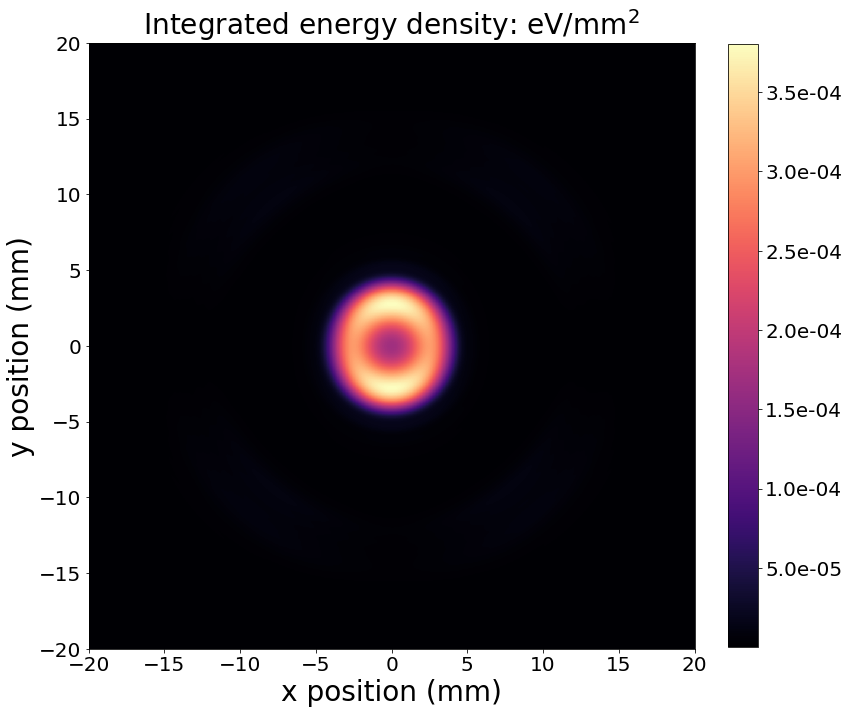

In [92]:
djmap = djL.sum(axis=0)*dE/qe/dx/dy/1e6
#djmapC1 = djC1_win.sum(axis=0)*dE/qe/dx**2/1e6

Imin = 0.5e-7; Ncon = 10;
dz = int(np.ceil((np.max(djmap)-Imin)/Ncon/0.00000001))*0.00000001

#c_list = np.exp(np.linspace(np.log(Imin),np.log(np.max(xyI2)),Ncon))
#c_list = np.arange(Imin, np.max(djmap), dz)
x_list = np.linspace(wfr.mesh.xStart, wfr.mesh.xFin, wfr.mesh.nx)*1000
y_list = np.linspace(wfr.mesh.yStart, wfr.mesh.yFin, wfr.mesh.ny)*1000

xmesh, ymesh = np.meshgrid(x_list,y_list)

plt.figure(figsize=(12,12))
cdensmap = plt.pcolormesh(xmesh, ymesh, djmap, cmap = 'magma')#,vmin=0, vmax=0.8e-3)
cdensmap.axes.set_ylim(np.min(ymesh), np.max(ymesh))
cdensmap.axes.set_xlim(np.min(xmesh), np.max(xmesh))
#cset = plt.contour(xmesh, ymesh, djmap, c_list,linewidths=2,cmap='gray_r',alpha = 1)
#plt.clabel(cset,inline=True,fmt='%.1e',fontsize=15)
cbar = plt.colorbar(cdensmap, fraction=0.045, format='%.1e')
cbar.ax.tick_params(labelsize=20)
plt.title('Integrated energy density: $\mathrm{eV/mm^{2}}$', fontsize=28)
plt.xlabel('x position (mm)', fontsize=28)
plt.ylabel('y position (mm)', fontsize=28)
plt.gca().set_aspect('equal', adjustable='box')
#plt.scatter(Lsubmap.lon.values,Lsubmap.lat.values, s= 35, c=Lsubmap.rides.values, cmap ='gray')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)

#plt.gca().set_xlim(-2,2)
#plt.gca().set_ylim(-2,2)

#plt.gca().set_xlim(-5.6256,5.6256)
#plt.gca().set_ylim(-3.516,3.516)
plt.show()

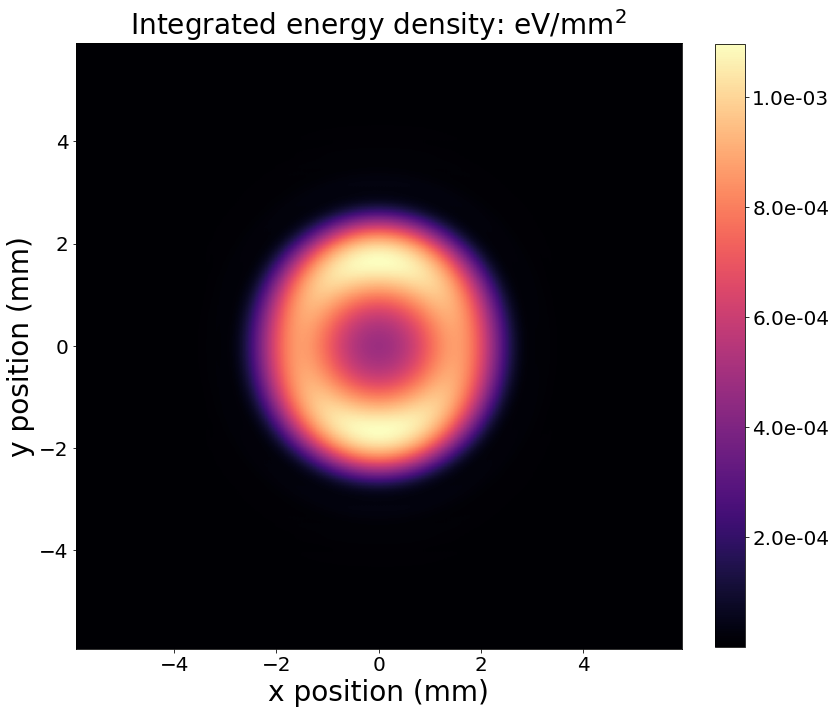

In [93]:
djmap = djC1.sum(axis=0)*dE/qe/dx1/dy1/1e6
#djmapC1 = djC1_win.sum(axis=0)*dE/qe/dx**2/1e6

Imin = 0.5e-7; Ncon = 10;
dz = int(np.ceil((np.max(djmap)-Imin)/Ncon/0.00000001))*0.00000001

#c_list = np.exp(np.linspace(np.log(Imin),np.log(np.max(xyI2)),Ncon))
#c_list = np.arange(Imin, np.max(djmap), dz)
x_list = np.linspace(wfr2.mesh.xStart, wfr2.mesh.xFin, wfr2.mesh.nx)*1000
y_list = np.linspace(wfr2.mesh.yStart, wfr2.mesh.yFin, wfr2.mesh.ny)*1000

xmesh, ymesh = np.meshgrid(x_list,y_list)

plt.figure(figsize=(12,12))
cdensmap = plt.pcolormesh(xmesh, ymesh, djmap, cmap = 'magma')
cdensmap.axes.set_ylim(np.min(ymesh), np.max(ymesh))
cdensmap.axes.set_xlim(np.min(xmesh), np.max(xmesh))
#cset = plt.contour(xmesh, ymesh, djmap, c_list,linewidths=2,cmap='gray_r',alpha = 1)
#plt.clabel(cset,inline=True,fmt='%.1e',fontsize=15)
cbar = plt.colorbar(cdensmap, fraction=0.045, format='%.1e')
cbar.ax.tick_params(labelsize=20)
plt.title('Integrated energy density: $\mathrm{eV/mm^{2}}$', fontsize=28)
plt.xlabel('x position (mm)', fontsize=28)
plt.ylabel('y position (mm)', fontsize=28)
plt.gca().set_aspect('equal', adjustable='box')
#plt.scatter(Lsubmap.lon.values,Lsubmap.lat.values, s= 35, c=Lsubmap.rides.values, cmap ='gray')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)

#plt.gca().set_xlim(-2,2)
#plt.gca().set_ylim(-2,2)

#plt.gca().set_xlim(-5.6256,5.6256)
#plt.gca().set_ylim(-3.516,3.516)
plt.show()

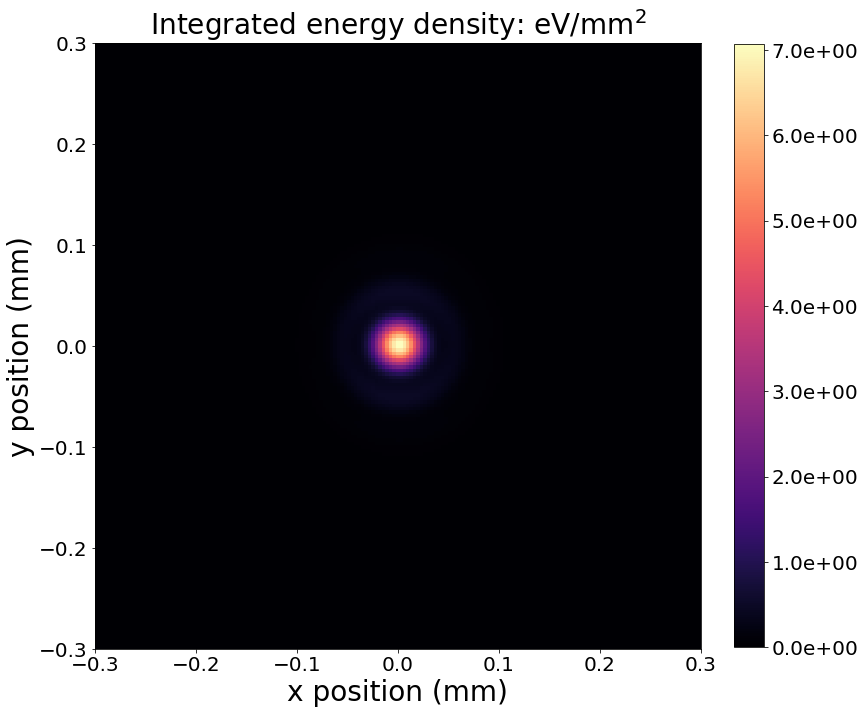

In [95]:
djmap = djC2.sum(axis=0)*dE/qe/dx2/dy2/1e6
#djmapC1 = djC1_win.sum(axis=0)*dE/qe/dx**2/1e6

Imin = 0.5e-7; Ncon = 10;
dz = int(np.ceil((np.max(djmap)-Imin)/Ncon/0.00000001))*0.00000001

#c_list = np.exp(np.linspace(np.log(Imin),np.log(np.max(xyI2)),Ncon))
c_list = np.arange(Imin, np.max(djmap), dz)
x_list = np.linspace(wfr3.mesh.xStart, wfr3.mesh.xFin, wfr3.mesh.nx)*1000
y_list = np.linspace(wfr3.mesh.yStart, wfr3.mesh.yFin, wfr3.mesh.ny)*1000

xmesh, ymesh = np.meshgrid(x_list,y_list)

plt.figure(figsize=(12,12))
cdensmap = plt.pcolormesh(xmesh, ymesh, djmap, cmap = 'magma')
cdensmap.axes.set_ylim(np.min(ymesh), np.max(ymesh))
cdensmap.axes.set_xlim(np.min(xmesh), np.max(xmesh))
#cset = plt.contour(xmesh, ymesh, djmap, c_list,linewidths=2,cmap='gray_r',alpha = 1)
#plt.clabel(cset,inline=True,fmt='%.1e',fontsize=15)
cbar = plt.colorbar(cdensmap, fraction=0.045, format='%.1e')
cbar.ax.tick_params(labelsize=20)
plt.title('Integrated energy density: $\mathrm{eV/mm^{2}}$', fontsize=28)
plt.xlabel('x position (mm)', fontsize=28)
plt.ylabel('y position (mm)', fontsize=28)
plt.gca().set_aspect('equal', adjustable='box')
#plt.scatter(Lsubmap.lon.values,Lsubmap.lat.values, s= 35, c=Lsubmap.rides.values, cmap ='gray')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)

plt.gca().set_xlim(-0.3,0.3)
plt.gca().set_ylim(-0.3,0.3)

#plt.gca().set_xlim(-5.6256,5.6256)
#plt.gca().set_ylim(-3.516,3.516)
plt.show()